In [47]:
import os
import numpy as np
import pandas as pd

import json

In [48]:
# Collect all results from the folder
fp_results = "./results/"

# Each subfolder is one model
models = [os.path.join(fp_results, model) for model in os.listdir(fp_results) if os.path.isdir(os.path.join(fp_results, model))]
models

# Add results of all json files of each model to a dict
results = {}
for model in models:
    results[model.split("/")[-1]] = {}

    for file in os.listdir(model):
        with open(os.path.join(model, file), "r") as f:
            results[model.split("/")[-1]][file.split(".")[0]] = json.load(f)

results.keys()

dict_keys(['cnn', 'gan', 'transformer'])

In [49]:
# Convert dict to pandas dataframe, only use mean
df = pd.DataFrame.from_dict({(i.capitalize(), j.capitalize()): results[i][j]
                             for i in results.keys()
                             for j in results[i].keys()},
                            orient="index")
# Extract mean from each index
df.index = pd.MultiIndex.from_tuples(df.index, names=["Model", "Fold"])
for col in df.columns:
    df[col] = df[col].apply(lambda x: x["mean"])

# Capitalise Transformer name, uppercase CNN and GAN
df.index = df.index.set_levels(df.index.levels[0].str.replace("Cnn", "CNN"), level=0)
df.index = df.index.set_levels(df.index.levels[0].str.replace("Gan", "GAN"), level=0)

# Replace column names
df.columns = df.columns.str.replace("cosine_similarity", "Cos-Sim")

# Df to latex, round to 3 decimals, add lines to the table
df.to_latex("./results/results.tex", float_format="{:0.3f}".format, caption="Results of the models on the test set.", label="tab:results")

df

C:\Users\denbe\AppData\Local\Temp\ipykernel_14636\2864888810.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex("./results/results.tex", float_format="{:0.3f}".format, caption="Results of the models on the test set.", label="tab:results")


L2  Cos-Sim    SSIM  MS-SSIM     FID
Model       Fold                                                 
CNN         100         14.0785   0.9867  0.9130   0.9600  3.5134
            1000        13.9526   0.9870  0.9130   0.9603  3.4787
            2500        13.9526   0.9870  0.9130   0.9603  3.4787
            Pretrained  14.2050   0.9878  0.9062   0.9582  3.4442
GAN         100         21.3724   0.9737  0.7999   0.9169  6.8803
            1000        21.2837   0.9742  0.8006   0.9174  6.8303
            2500        21.2793   0.9748  0.7997   0.9164  6.8058
            Pretrained  21.3850   0.9736  0.7998   0.9167  6.8983
Transformer 100         15.2197   0.9787  0.9014   0.9495  4.7577
            1000        14.3608   0.9806  0.9060   0.9538  4.1490
            2500        15.0630   0.9804  0.9041   0.9536  4.4144
            Pretrained  15.7576   0.9780  0.8947   0.9475  4.8612

In [50]:
from scipy.stats import ttest_ind

models = ["Original", "CNN", "Transformer", "GAN"]
means = [1.417, 2.563, 2.462, 3.559]
stds = [0.566, 0.601, 0.652, 0.523]
alpha = 0.05

# Perform t-test on each of the combinations of models
df_ttest = pd.DataFrame(columns=["Model 1", "Model 2", "p-value", "t-statistic"])
for i in range(len(models)):
    for j in range(i+1, len(models)):
        statistic, pvalue = ttest_ind([means[i], means[j]], [stds[i], stds[j]], equal_var=True, alternative="two-sided")

        # Rounded to 3 decimals
        print(f"p-value: {round(pvalue, 3)}; statistical significance: {pvalue < alpha}; {models[i]} vs {models[j]}")
        df_ttest = pd.concat([df_ttest, pd.DataFrame([[models[i], models[j], round(pvalue, 3), round(statistic, 3)]],
                             columns=["Model 1", "Model 2", "p-value", "t-statistic"])], ignore_index=True)

# Sort by p-value
df_ttest.sort_values(by="p-value", inplace=True)
df_ttest


p-value: 0.134; statistical significance: False; Original vs CNN
p-value: 0.126; statistical significance: False; Original vs Transformer
p-value: 0.211; statistical significance: False; Original vs GAN
p-value: 0.001; statistical significance: True; CNN vs Transformer
p-value: 0.038; statistical significance: True; CNN vs GAN
p-value: 0.048; statistical significance: True; Transformer vs GAN


,Model 1,Model 2,p-value,t-statistic
3,CNN,Transformer,0.001,33.337
4,CNN,GAN,0.038,5.003
5,Transformer,GAN,0.048,4.387
1,Original,Transformer,0.126,2.538
0,Original,CNN,0.134,2.453
2,Original,GAN,0.211,1.814


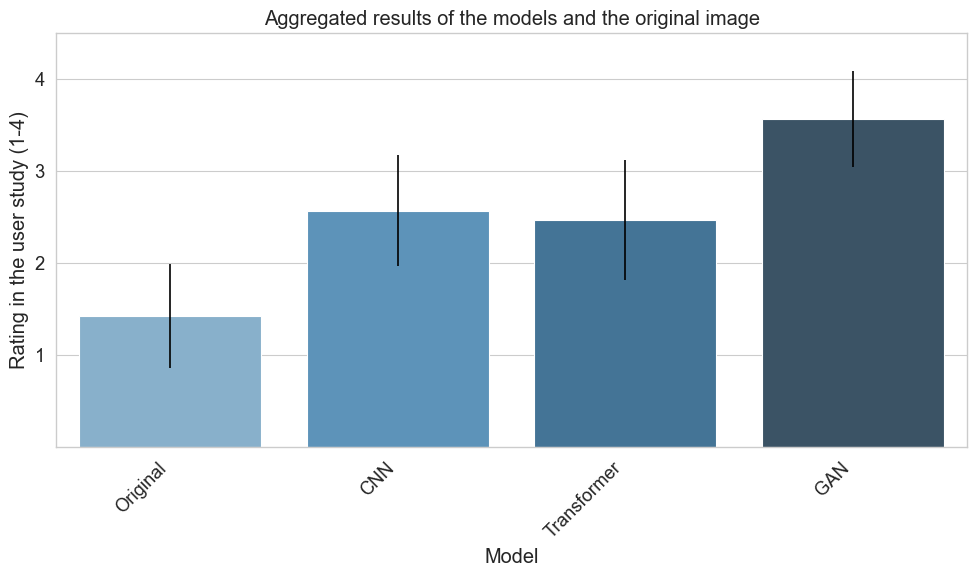

In [51]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=models, y=means, yerr=stds, capsize=.2, palette="Blues_d")
ax.set_ylabel("Rating in the user study (1-4)")
ax.set_xlabel("Model")
ax.set_title("Aggregated results of the models and the original image")
ax.set_ylim(0, 4.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# Set y tick labels to 1, 2, 3, 4
ax.set_yticks([1, 2, 3, 4])
plt.tight_layout()
plt.savefig("./images/ttest.png", dpi=300)
plt.show()